#  HR-аналитика компании «Работа с заботой»

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Наши задачи**
У нас будет несколько задач. 
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных для первой задачи**

Для первой задачи заказчик предоставил данные с признаками:
 - `id` — уникальный идентификатор сотрудника;
 - `dept` — отдел, в котором работает сотрудник;
 - `level` — уровень занимаемой должности;
 - `workload` — уровень загруженности сотрудника;
 - `employment_years` — длительность работы в компании (в годах);
 - `last_year_promo` — показывает, было ли повышение за последний год;
 - `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
 - `salary` — ежемесячная зарплата сотрудника;
 - `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
 
**Описание данных для второй задачи**

Для этой задачи мы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
import shap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42

Кроме того, напишем функции, которые пригодятся нам в дальнейшей работе.

In [9]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def information(df):
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())

In [10]:
# Функция создает для списка столбцов два графика - гистограмму и ящик с усами.
def todoplot(df):
    for i in col:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

In [11]:
# Для оценки качества моделей напишем функцию, 
# которая будет вычислять метрику SMAPE (симметричное среднее абсолютное процентное отклонение).
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

In [12]:
# Функция создает для списка одинаковых столбцов из двух датасетов две круговых диаграммы.
def todopie(df,df1,title,ylabel):
    for i in cols:
        fig, axes = plt.subplots(1, 2, figsize=(15,10))
        t1=df.pivot_table(index=i, values='id', aggfunc='count')
        t2=df1.loc[df1[i] != ' '].pivot_table(index=i, values='id', aggfunc='count')
        labels=t1.index.unique()
        axes[0].pie(t1['id'], autopct='%1.0f%%', labels=labels)
        axes[0].set(ylabel=ylabel, title=title);
        axes[1].pie(t2['id'], autopct='%1.0f%%', labels=labels);
        axes[1].set(ylabel=ylabel, title=title);
        plt.legend(bbox_to_anchor=(1, 0.6));
        plt.show()

In [13]:
# Функция для создания пайплайна.
# Cоздадим пайпы для подготовки данных: для признаков, которые будет кодировать OneHotEncoder, 
# для признаков, которые будем кодировать OrdinalEncoder (включим в пайпы обработку пропусков с помощью SimpleImputer). 
# Затем соединим полученные пайпы в data_preprocessor, туда же добавим масштабирование количественных признаков.
def pipe(ohe_columns, ord_columns, num_columns):
    global pipe_final
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore')
            )
        ]
    ) 

    ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

## 1 Задача 1

### Загрузка данных

In [17]:
try:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    train = pd.read_csv('train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('test_features.csv')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')

#### Изучим общую информацию о данных

In [20]:
# Функция для общей информации о данных
def information(dataset):
    display(dataset.head())
    display(dataset.tail())
    print(dataset.info())
    print('Количество пропусков:\n', dataset.isna().sum())
    print('Количество явных дубликатов:', dataset.duplicated().sum())
    display(dataset.describe().T)

In [21]:
information(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None
Количество пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_viola

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


**Вывод для `train`:** 
* Есть пропуски в столбцах `dept`, `level`
* Формат данных соответствует необходимому
* Явные дубликаты отсутствуют 

In [23]:
information(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
Количество пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


**Вывод для `X_test`:** 
* Есть пропуски в столбцах `dept`, `level`
* Формат данных соответствует необходимому
* Явные дубликаты отсутствуют 

In [25]:
information(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26
1999,648995,0.62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None
Количество пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64
Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


**Вывод для `y_test`:** 
* Пропусков нет
* Формат данных соответствует необходимому
* Явные дубликаты отсутствуют 

### Предобработка данных

In [28]:
# Неявные дубликаты train
print ('Уникальные значение в таблице train:')
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    print (train[i].unique())

Уникальные значение в таблице train:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


In [29]:
# Неявные дубликаты X_test
print ('Уникальные значение в таблице train:')
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    print (X_test[i].unique())

Уникальные значение в таблице train:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [30]:
# Пайплайн для замены пропущенных значений
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [31]:
# Посмотрим на пропущенные значения train
train[train['dept'].isnull() | train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [32]:
# Заменим пропущенные значения train
nan_cols = ['dept', 'level', 'workload']
train[nan_cols] = imputer_pipe.fit_transform(train[nan_cols])

# Проверка
print(f'Количество пропущенных значений после замены: \n {train.isna().sum()}')

Количество пропущенных значений после замены: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [33]:
# Посмотрим на пропущенные значения X_test
X_test[X_test['dept'].isnull() | X_test['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [34]:
# Заменим "пустое" значение dept и workload на NaN 
X_test['dept'].replace({' ': np.nan}, inplace=True)
X_test['workload'].replace({' ': np.nan}, inplace=True)

In [36]:
# Заменим пропущенные значения X_test
X_test[nan_cols] = imputer_pipe.transform(X_test[nan_cols])

# Проверка
print(f'Количество пропущенных значений после замены: \n {X_test.isna().sum()}')

Количество пропущенных значений после замены: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


**Вывод:** Видим, что в общем все значения уникальны и правильно прописаны, от пропусков в данных избавились

### Исследовательский анализ данных train выборки

In [44]:
# Списки столбцов категориальные
cat_col_train = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations']
# Списки столбцов количественные
num_col_train = ['salary','job_satisfaction_rate']
# Дискретные признаки
train_di = ['employment_years','supervisor_evaluation']

In [45]:
# Функции для построения гистограммы, диаграммы размаха для столбцов с количественными признаками
def hist_box(data, column):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'{column}')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма {column}')
    sns.histplot(data[column], color='hotpink')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'{column}')
    plt.title(f'Диаграмма размаха {column}')
    sns.boxplot(x=data[column], color='teal')

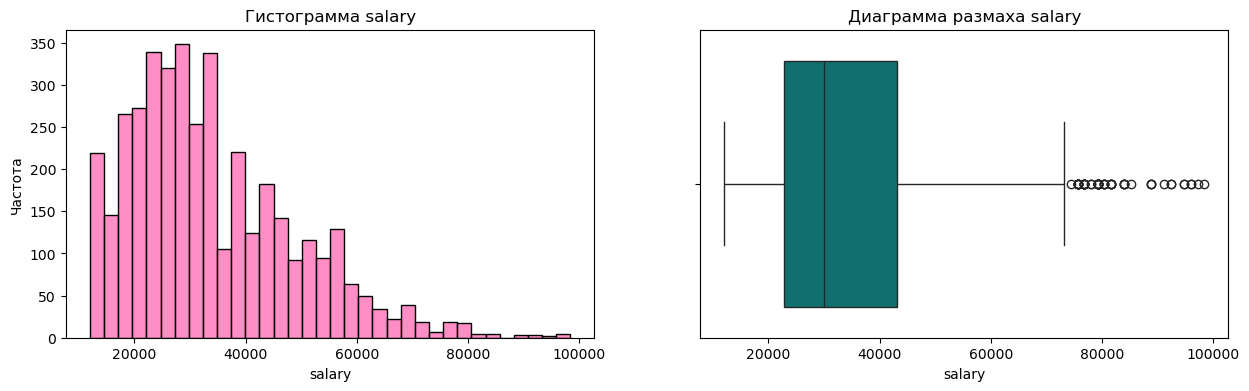

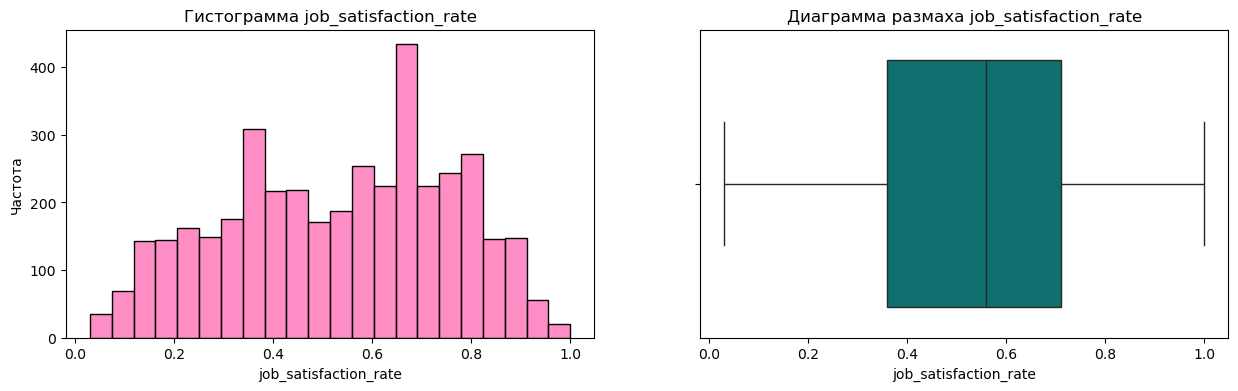

In [46]:
for name in num_col_train:
    hist_box(train, name)

**Вывод:** 
* `salary` распределен не совсем нормально, имеется сдвиг влево. На диаграмме мы видим выбросы, но так как они достигают 100 000, что является абсолютно реальным зарплатным решением, удалять их не стоит. Вполне логично, что людей с высокой зарплатой меньше, поэтому такие значения определяются как выбросы.
* `job_satisfaction_rate` тоже имеет не совсем нормальное распределение, сдвиг идет вправо. Выбросов не наблюдается

In [48]:
# Функция для построения гистограммы, диаграммы размаха для столбцов с дискретными признаками
def hist_box_di(data, column):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'{column}')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма {column}')
    sns.countplot(data = data, x = data[column], color='hotpink')

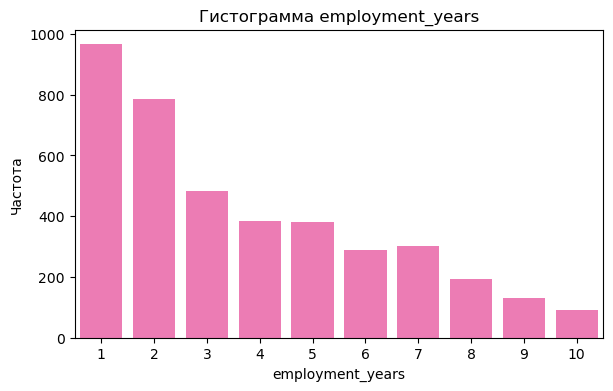

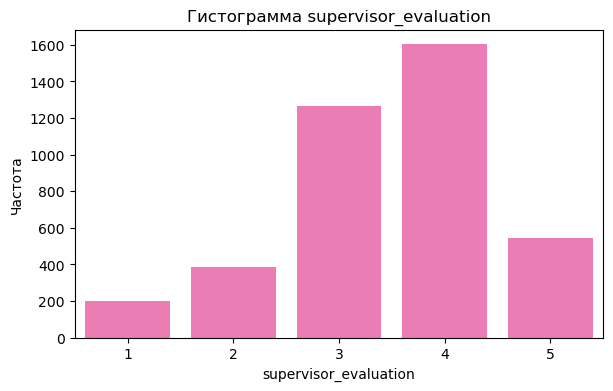

In [49]:
for name in train_di:
    hist_box_di(train, name)

**Вывод:** 

* `employment_years` преобладают сотрудники, которые работают в компании один год, видно, что чем больше лет в компании, тем меньше сотрудников.
* `supervisor_evaluation` в оценках сотрудников преобладают оценки 3 и 4. 

In [51]:
# Функция для круговой диаграммы категориальных признаков
def pie_graph(dataset, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)[name].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('Pastel1'))

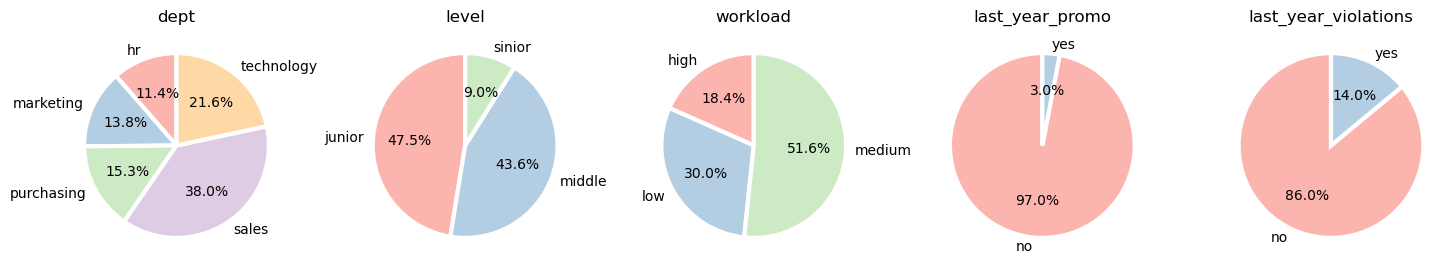

In [52]:
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_train:
    pie_graph(train, name, 'id', len(cat_col_train), i)
    i += 1

**Вывод:** 

* `dept` преобладают сотрудники, которые работают в отделе продаж, на втором место технический, остальные распределены примерно одинаково.
* `level` по уровню занимаемой должности равномерно преобладаются junior и middle сотрудники, senior меньше, что логично, сотрудников с таким опытом всегда мало.
* `workload` по уровню загруженности самый большой сегмент отвечает за среднюю, на втором месте низкий, высокий уровень загруженности - самый не многочисленный.
* `last_year_promo` повышение за прошлый год было только у 3% сотрудников.
* `last_year_violations` нарушение договора за прошлый год выявлено у 14% сотрудников.

### Исследовательский анализ test выборки

In [55]:
# Списки столбцов категориальные
cat_col_test = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations']
# Списки столбцов количественные
num_col_test = ['salary']
# Дискретные признаки
train_test = ['employment_years','supervisor_evaluation']

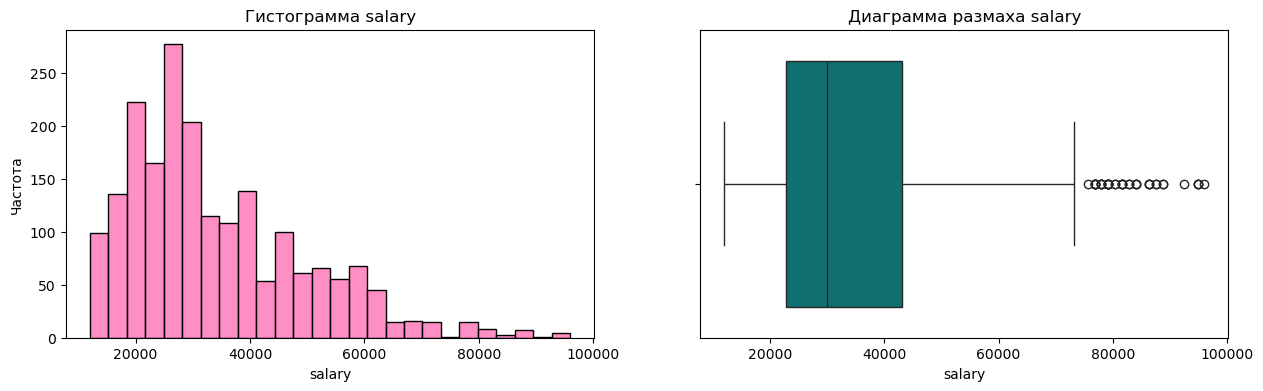

In [56]:
for name in num_col_test:
    hist_box(X_test, name)

**Вывод:** 
* `salary` имеет такое же не совсем нормальное распределение, как и в тренировочной выборке, с очевидным сдвигом влево. На диаграмме выбросы сохраняются тоже по принципу, как в тренировочной выборке. 
* `job_satisfaction_rate` является целевым признаком, поэтому его нет в тестовой выборке со всеми остальными признаками.

**Данные для тренировочной и тестовой выборок гармоничны, поэтому никаких изменений не требуется.**

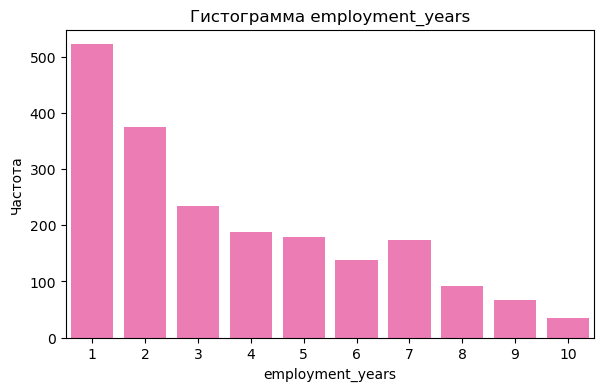

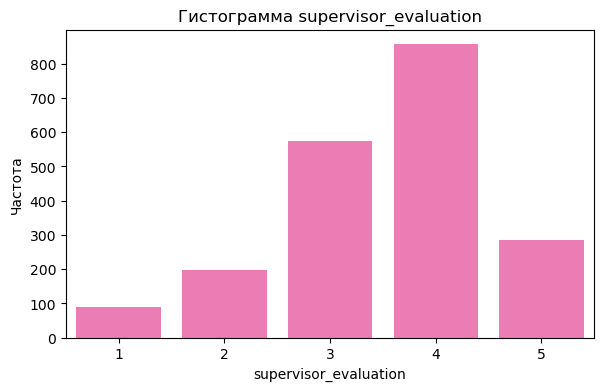

In [58]:
for name in train_test:
    hist_box_di(X_test, name)

**Вывод:** 

* `employment_years` преобладают сотрудники, которые работают в компании один год, как и в тренировочной выборке.
* `supervisor_evaluation` в оценках сотрудников преобладают оценки 3 и 4, как и в тренировочной выборке.

**Данные для двух выборок гармоничны.** 

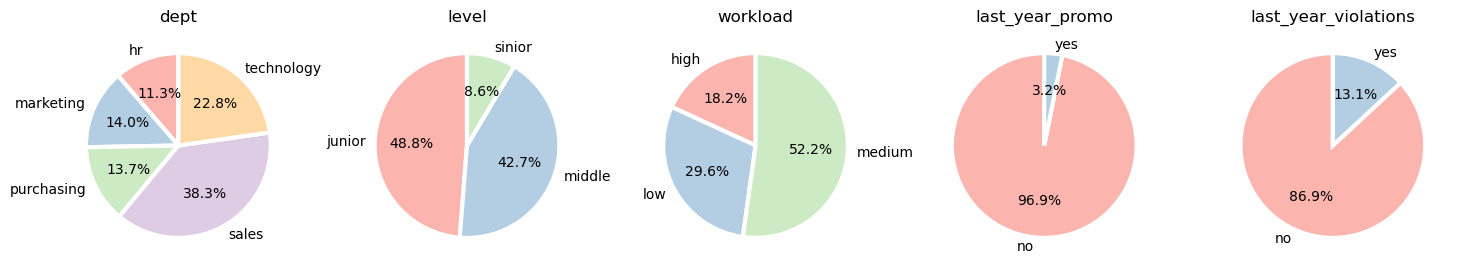

In [60]:
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_test:
    pie_graph(X_test, name, 'id', len(cat_col_test), i)
    i += 1

**Вывод:** 

* `dept` преобладают сотрудники, которые работают в отделе продаж, на втором место технический, остальные распределены примерно одинаково, как и в тренировчной выборке.
* `level` по уровню занимаемой должности равномерно преобладают junior и middle сотрудники, senior меньше, что логично, сотрудников с таким опытом всегда мало, как и в тренировчной выборке.
* `workload` по уровню загруженности самый большой сегмент отвечает за среднюю, на втором месте низкий, высокий уровень загруженности - самый не многочисленный, как и в тренировчной выборке.
* `last_year_promo` повышение за прошлый год было только у 3% сотрудников, как и в тренировчной выборке.
* `last_year_violations` нарушение договора за прошлый год выявлено у 13% сотрудников, как и в тренировчной выборке.

**Данные в выборках гармоничны.**

### Корелляционный анализ train

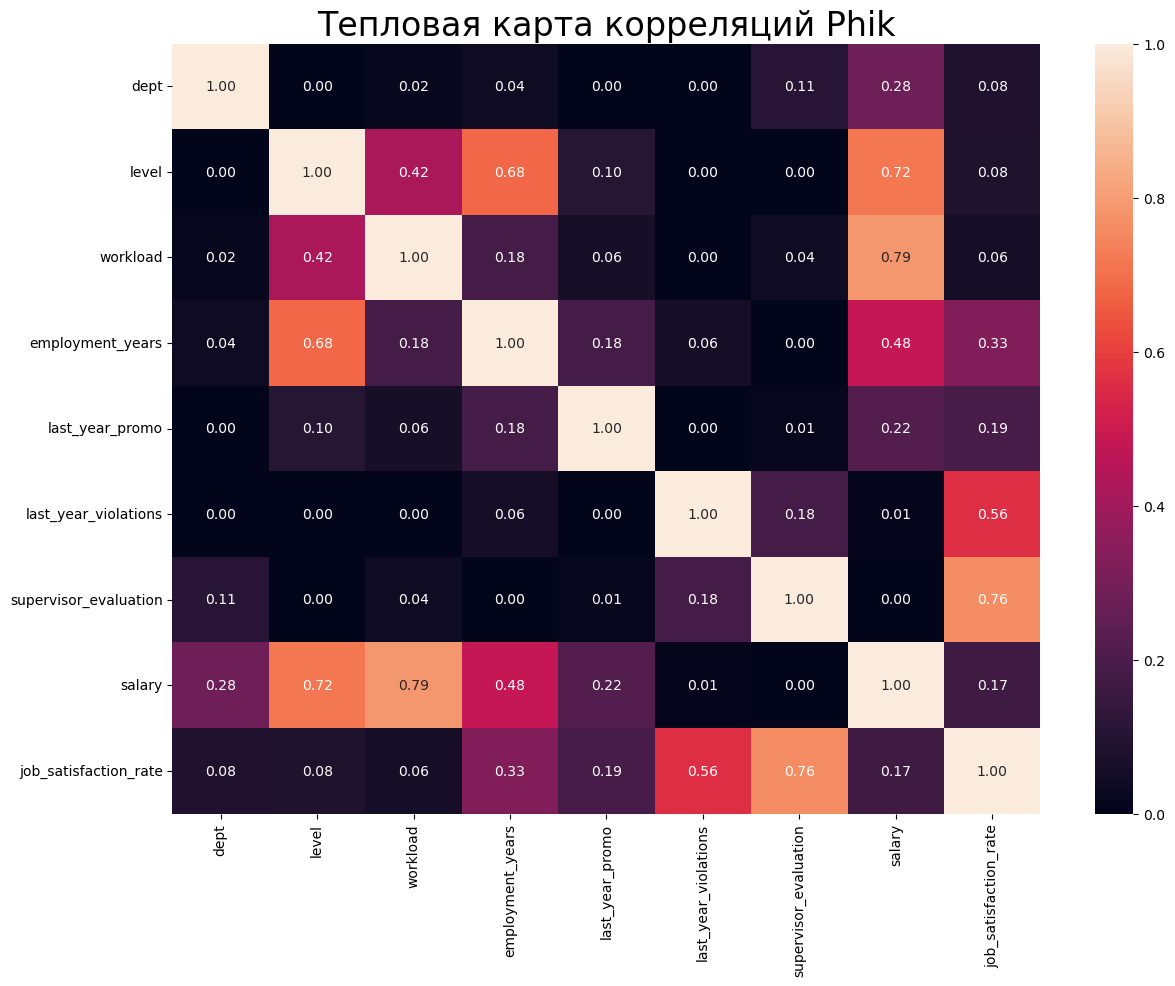

In [64]:
plt.figure(figsize=(14,10))
sns.heatmap(train.drop('id', axis = 1).phik_matrix(interval_cols=['salary',
                                             'job_satisfaction_rate']), annot = True, fmt = '.2f')
plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.show()

### Корелляционный анализ test

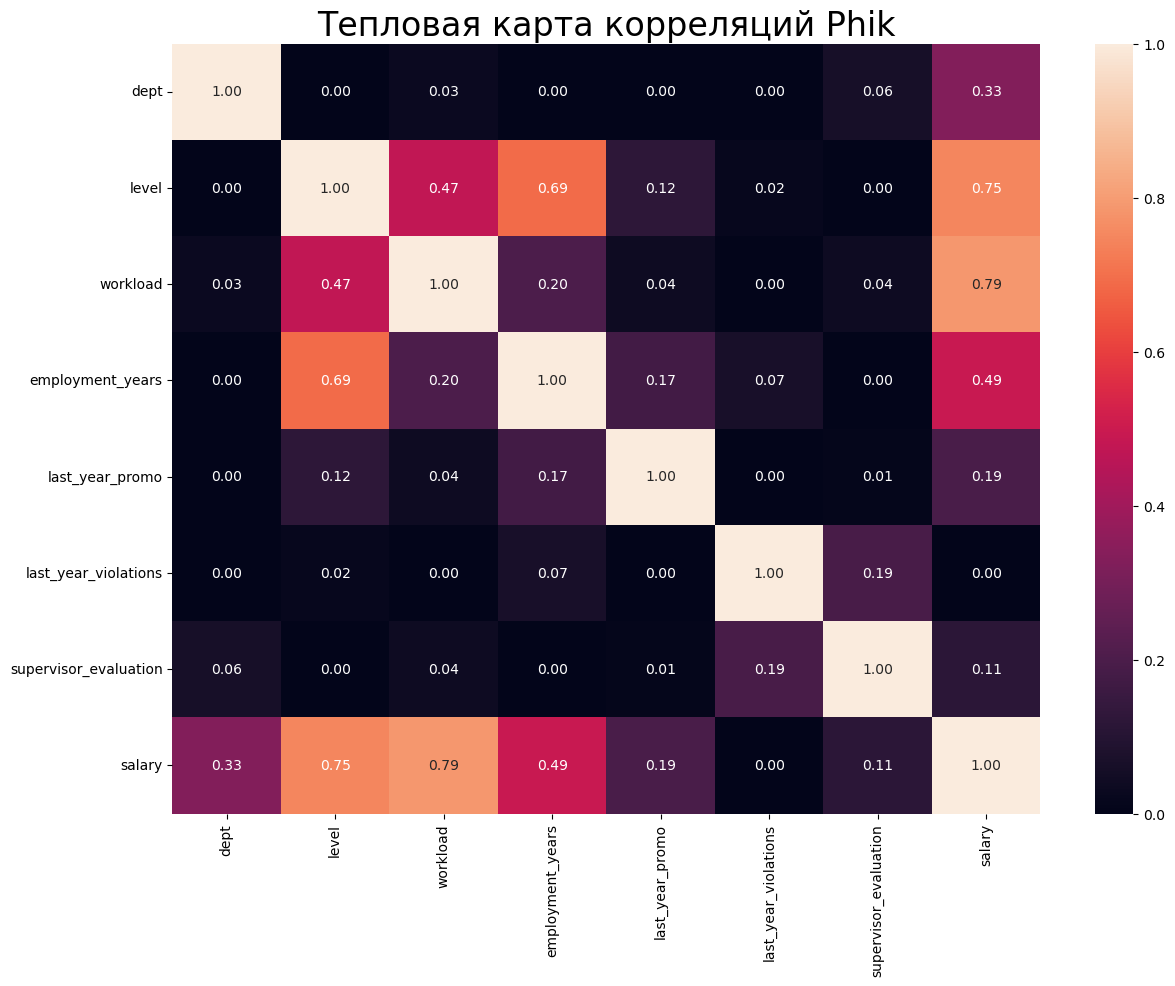

In [66]:
plt.figure(figsize=(14,10))
sns.heatmap(X_test.drop('id', axis = 1).phik_matrix(interval_cols=['salary']), annot = True, fmt = '.2f')
plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.show()

Утечки целевого признака не обнаружено.

***Вывод:*** Таким образом, мы провели исследовательский анализ данных, посмотрели распределение данных во всех таблицах, по итогам анализа можно сказать, что данные выглядят достоверно, особых выбросов нет, при проведении корреляционного анализа утечки целевого признака не обнаружено. Перед обучением необходимо будет провести подготовку данных в пайплайне: масштабирование количественных признаков, кодирование категориальных признаков, обработку пропусков.

### Подготовка данных

In [78]:
# Избавляемся от признака id 
train_temp = train.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp.duplicated().sum())

Количество дубликатов: 248


**После того, как мы избавились от признака `id` появились дубликаты, который необходимо удалить. Такие данные в обучающей выборке не приносят дополнительной информации в модель, но создают необоснованный вес таким наблюдениям.**

In [80]:
train_temp = train_temp.drop_duplicates().reset_index(drop=True)

In [82]:
# Подготовим тренировочный датасет по целевому признаку
X_train = train_temp.drop(['job_satisfaction_rate'], axis=1)
y_train = train_temp['job_satisfaction_rate']

In [83]:
# Соединим таблицы с тестовыми данными и целевым признаком
test = X_test.merge(y_test, on='id')

In [84]:
# Подготовим тестовый датасет по целевому признаку
X_test_ = test.drop(['job_satisfaction_rate','id'], axis=1)
y_test_ = test['job_satisfaction_rate']

Теперь определим наши признаки и запустим функцию создания пайплайна.

In [86]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 

In [87]:
pipe(ohe_columns, ord_columns, num_columns)

***Вывод:*** На этом этапе мы провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна. И теперь мы готовы приступить к обучению моделей.

### Обучение моделей

Так как целевой признак у нас непрерывный количественный, то для для обучения будем брать модели регрессии: модель линейной регрессии и дерево решений (для дерева решений используем перебор разных гиперпараметров). 

In [91]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 11),
        'models__max_features': range(5, 11)
    },
 
    {
        'models': [LinearRegression()]
    }
]

In [92]:
# Создадим свою метрику SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

In [94]:
# Обучение перебором гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
                                                                         StandardScaler(),
                                                                         ['salary',
                                                                          'employment_years',
                                                                          'supervisor_evaluation'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 11),
                          'models__max_features': range(5, 11)},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [95]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

**Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10.**

In [99]:
y_pred_test = grid.best_estimator_.predict(X_test_)
smape_test = smape(y_test_, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 14.95987015329265


**Метрика получилась равной 14.95, что даже лучше, чем на тренировочной выборке, значит наша модель работает хорошо.**

### Выводы

Мы выполнили первую поставленную перед нами задачу: построили модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

* Провели обучение моделей, выбрали лучшую на основе метрики SMAPE.
* Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10.
* После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.
* Вероятно дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров.

## Задача 2 

### Загрузка данных

In [108]:
try:
    train1 = pd.read_csv('/datasets/train_quit.csv')
    y_test1 = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train1 = pd.read_csv('train_quit.csv')
    y_test1 = pd.read_csv('test_target_quit.csv')

In [109]:
X_test1 = X_test

In [110]:
information(train1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None
Количество пропусков:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_e

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


In [111]:
information(y_test1)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
Количество пропусков:
 id      0
quit    0
dtype: int64
Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


***Вывод***: В новых датасетах пропусков и дублей нет. В тренировочной выборке всё так же 4000 строк, в тестовой 2000.

### Предобработка данных

Нужно убедиться, что в новых данных нет ошибок и аномальных значений.

In [115]:
# Неявные дубликаты train1
print ('Уникальные значение в таблице train1:')
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    print (train1[i].unique())

Уникальные значение в таблице train1:
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']


In [116]:
# Неявные дубликаты y_test1
print('Уникальные значение в таблице y_test1:', y_test1['quit'].unique())

Уникальные значение в таблице y_test1: ['yes' 'no']


**Вывод:** С уникальными значениями все в порядке

### Исследовательский анализ train

In [119]:
# Списки столбцов категориальные
cat_col_train1 = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations', 'quit']
# Списки столбцов количественные
num_col_train1 = ['salary']
# Дискретные признаки
train_di1 = ['employment_years','supervisor_evaluation']

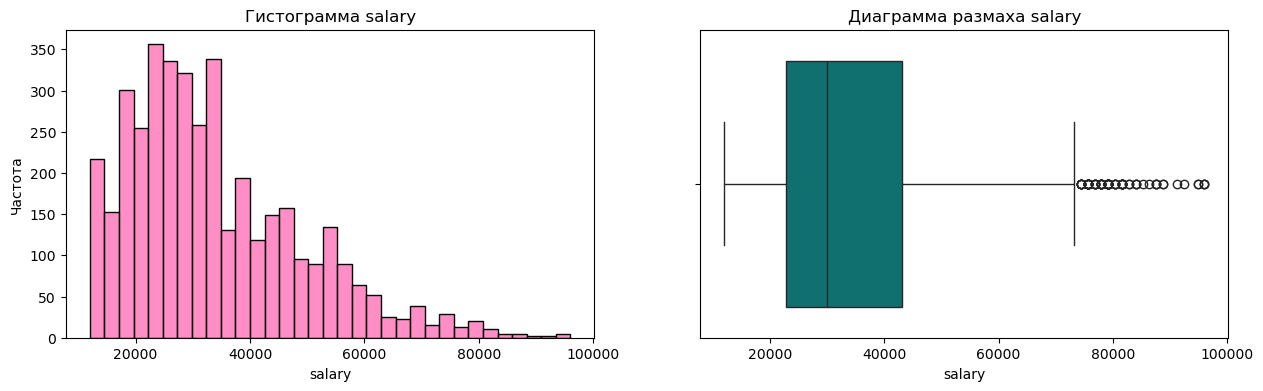

In [120]:
for name in num_col_train1:
    hist_box(train1, name)

**Вывод:** 
* `salary` распределен не совсем нормально, имеется сдвиг влево. На диаграмме мы видим выбросы, но так как они достигают 100 000, что является абсолютно реальным зарплатным решением, удалять их не стоит. Вполне логично, что людей с высокой зарплатой меньше, поэтому такие значения определяются как выбросы.

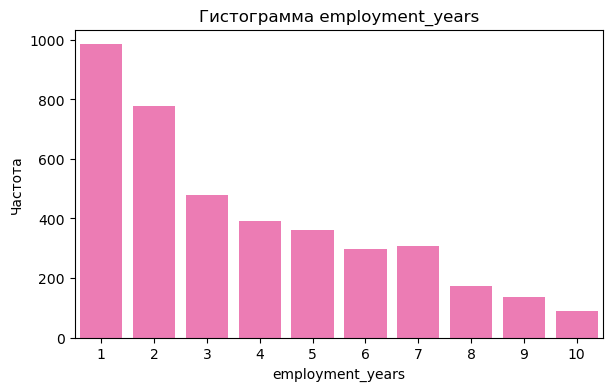

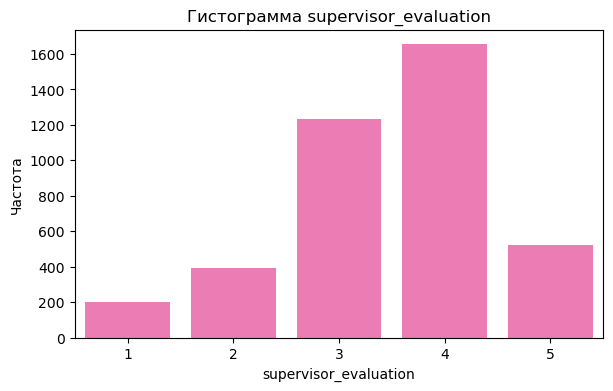

In [122]:
for name in train_di1:
    hist_box_di(train1, name)

**Вывод:** 

* `employment_years` преобладают сотрудники, которые работают в компании один год, видно, что чем больше лет в компании, тем меньше сотрудников.
* `supervisor_evaluation` в оценках сотрудников преобладают оценки 3 и 4. 

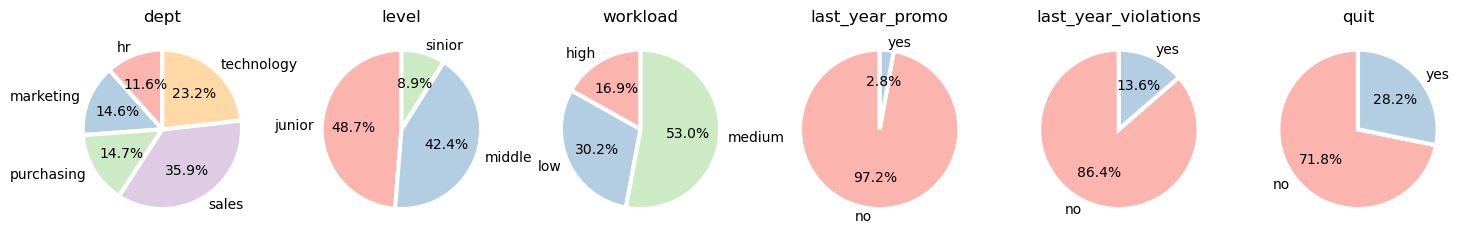

In [124]:
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_train1:
    pie_graph(train1, name, 'id', len(cat_col_train1), i)
    i += 1

**Вывод:** 

* `dept` преобладают сотрудники, которые работают в отделе продаж, на втором место технический, остальные распределены примерно одинаково.
* `level` по уровню занимаемой должности равномерно преобладают junior и middle сотрудники, senior меньше, что логично, сотрудников с таким опытом всегда мало.
* `workload` по уровню загруженности самый большой сегмент отвечает за среднюю, на втором месте низкий, высокий уровень загруженности - самый не многочисленный.
* `last_year_promo` повышение за прошлый год было только у 2.8% сотрудников.
* `last_year_violations` нарушение договора за прошлый год выявлено у 13.6% сотрудников.
* `quit` уволнение выявлено у 28% сотрудников, что является достаточно значимым показателем для компании.

**Составим портрет «уволившегося сотрудника».**

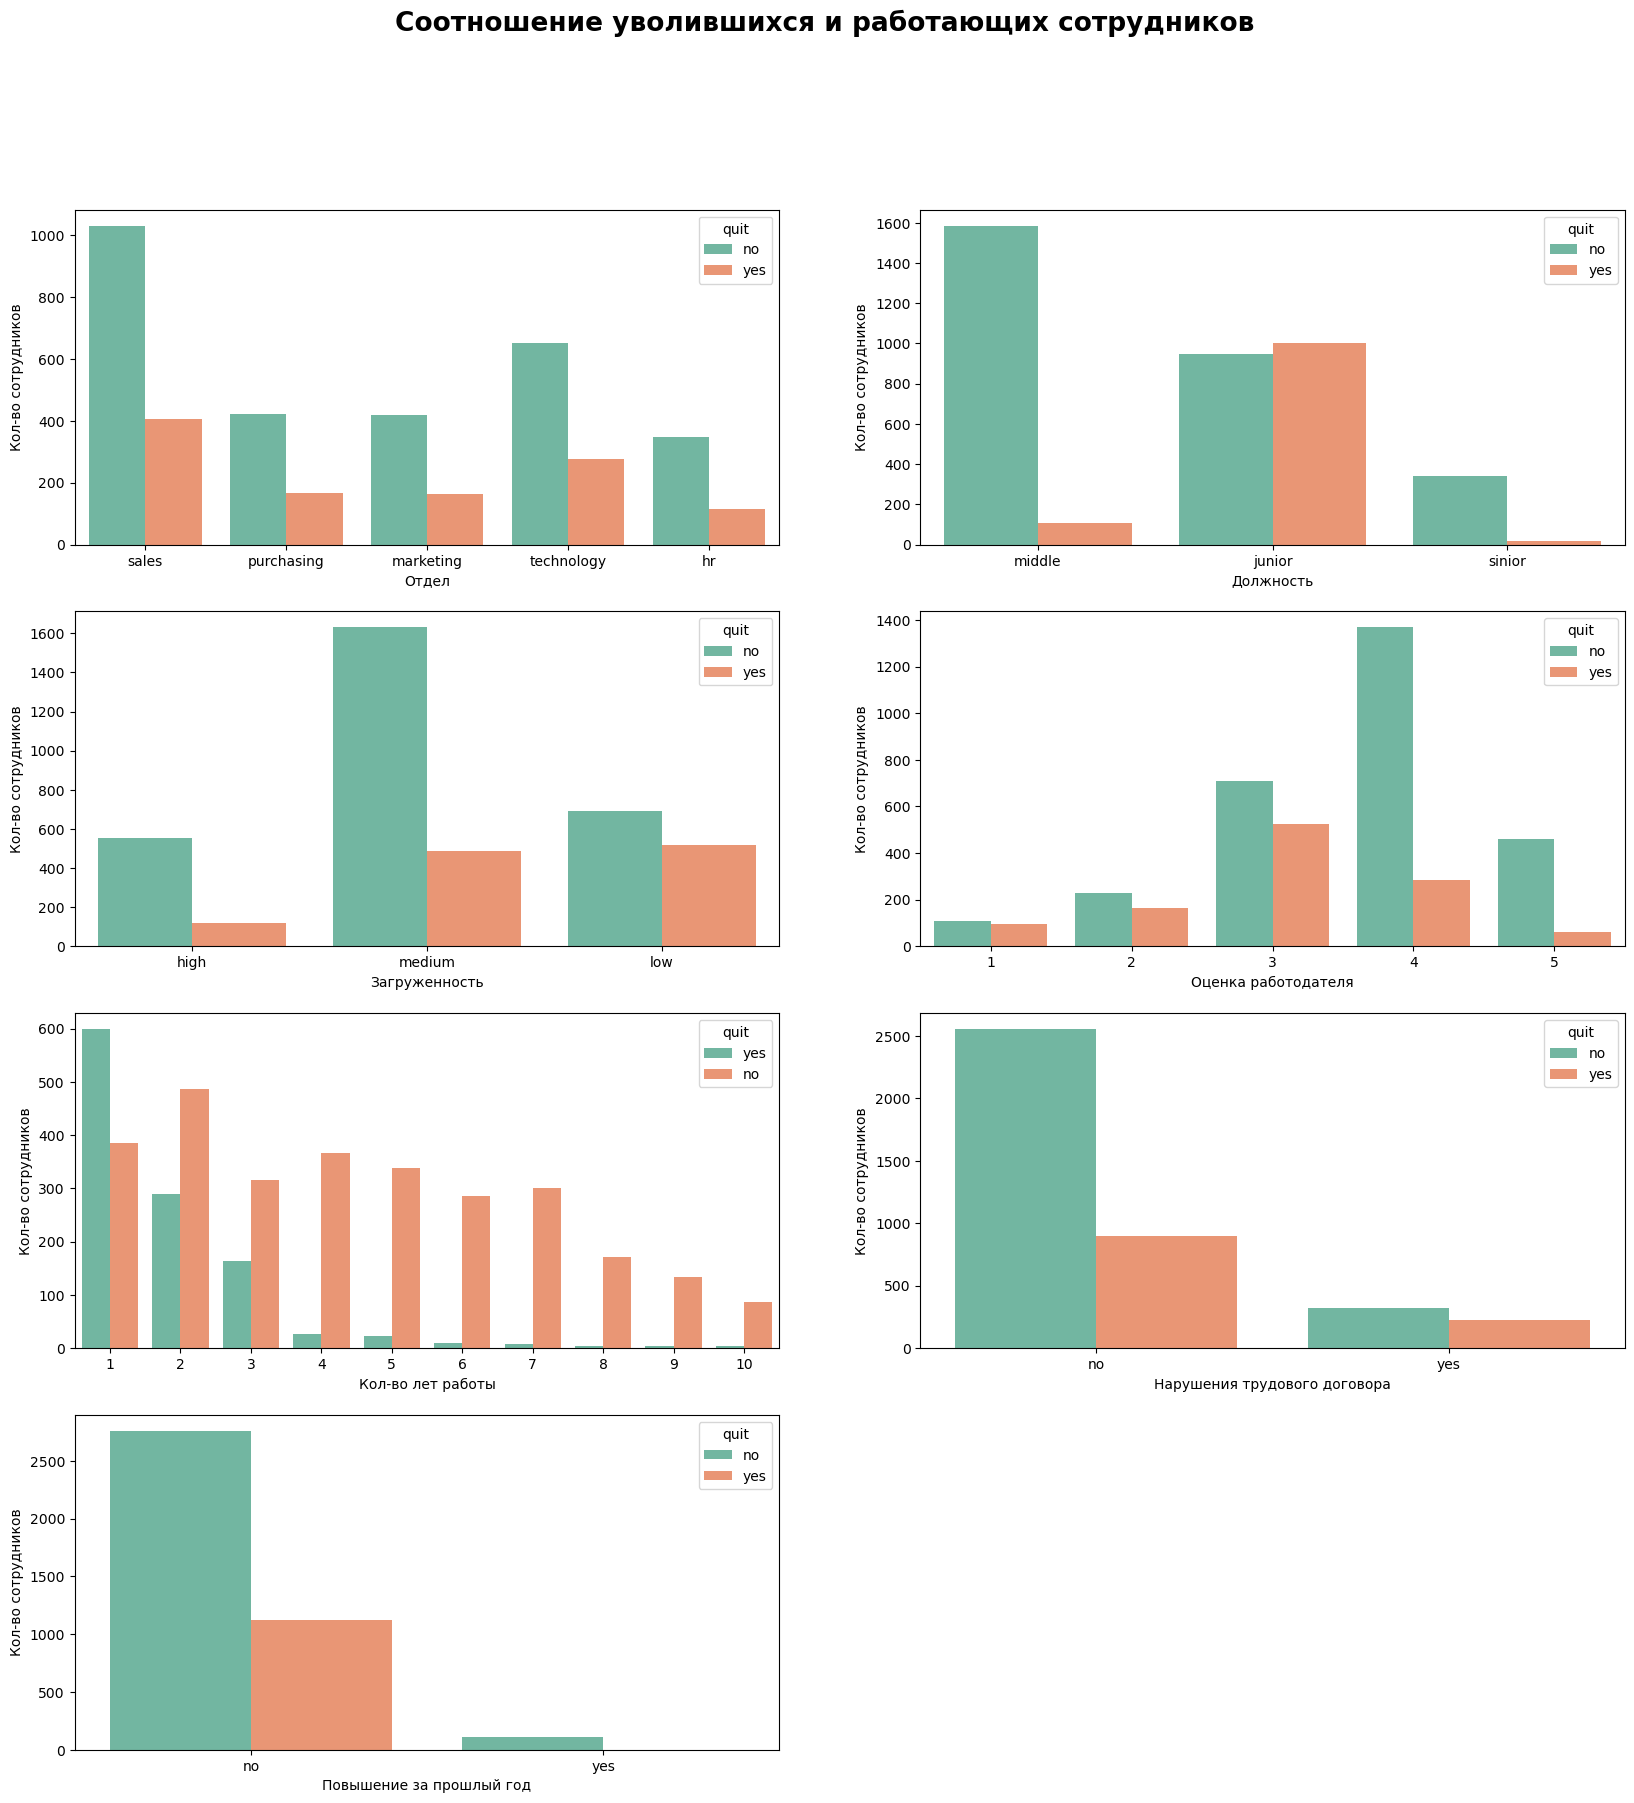

In [130]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')
sns.countplot(x ='dept', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[0,0]).set(xlabel='Отдел', ylabel='Кол-во сотрудников');
sns.countplot(x ='level', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[0,1]).set(xlabel='Должность', ylabel='Кол-во сотрудников');
sns.countplot(x ='workload', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[1,0]).set(xlabel='Загруженность', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[2,0]).set(xlabel='Кол-во лет работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_violations', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_promo', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[3,0]).set(xlabel='Повышение за прошлый год', ylabel='Кол-во сотрудников');
fig.delaxes(axes[3,1])

In [135]:
# Список категориальных/дискретных признаков
categorical_features = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations', 'employment_years','supervisor_evaluation' ]

# Фильтруем только уволившихся
quit_yes = train1[train1['quit'] == 'yes']

# Вывод долей уволившихся по каждому признаку
for feature in categorical_features:
    print(f"Распределение уволившихся по признаку {feature} (относительные величины):")
    print(quit_yes[feature].value_counts(normalize=True))
    print('\n')

Распределение уволившихся по признаку dept (относительные величины):
dept
sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: proportion, dtype: float64


Распределение уволившихся по признаку level (относительные величины):
level
junior    0.889184
middle    0.095745
sinior    0.015071
Name: proportion, dtype: float64


Распределение уволившихся по признаку workload (относительные величины):
workload
low       0.460106
medium    0.432624
high      0.107270
Name: proportion, dtype: float64


Распределение уволившихся по признаку last_year_promo (относительные величины):
last_year_promo
no     0.999113
yes    0.000887
Name: proportion, dtype: float64


Распределение уволившихся по признаку last_year_violations (относительные величины):
last_year_violations
no     0.797872
yes    0.202128
Name: proportion, dtype: float64


Распределение уволившихся по признаку employment_years (относительные величины):
employment_years


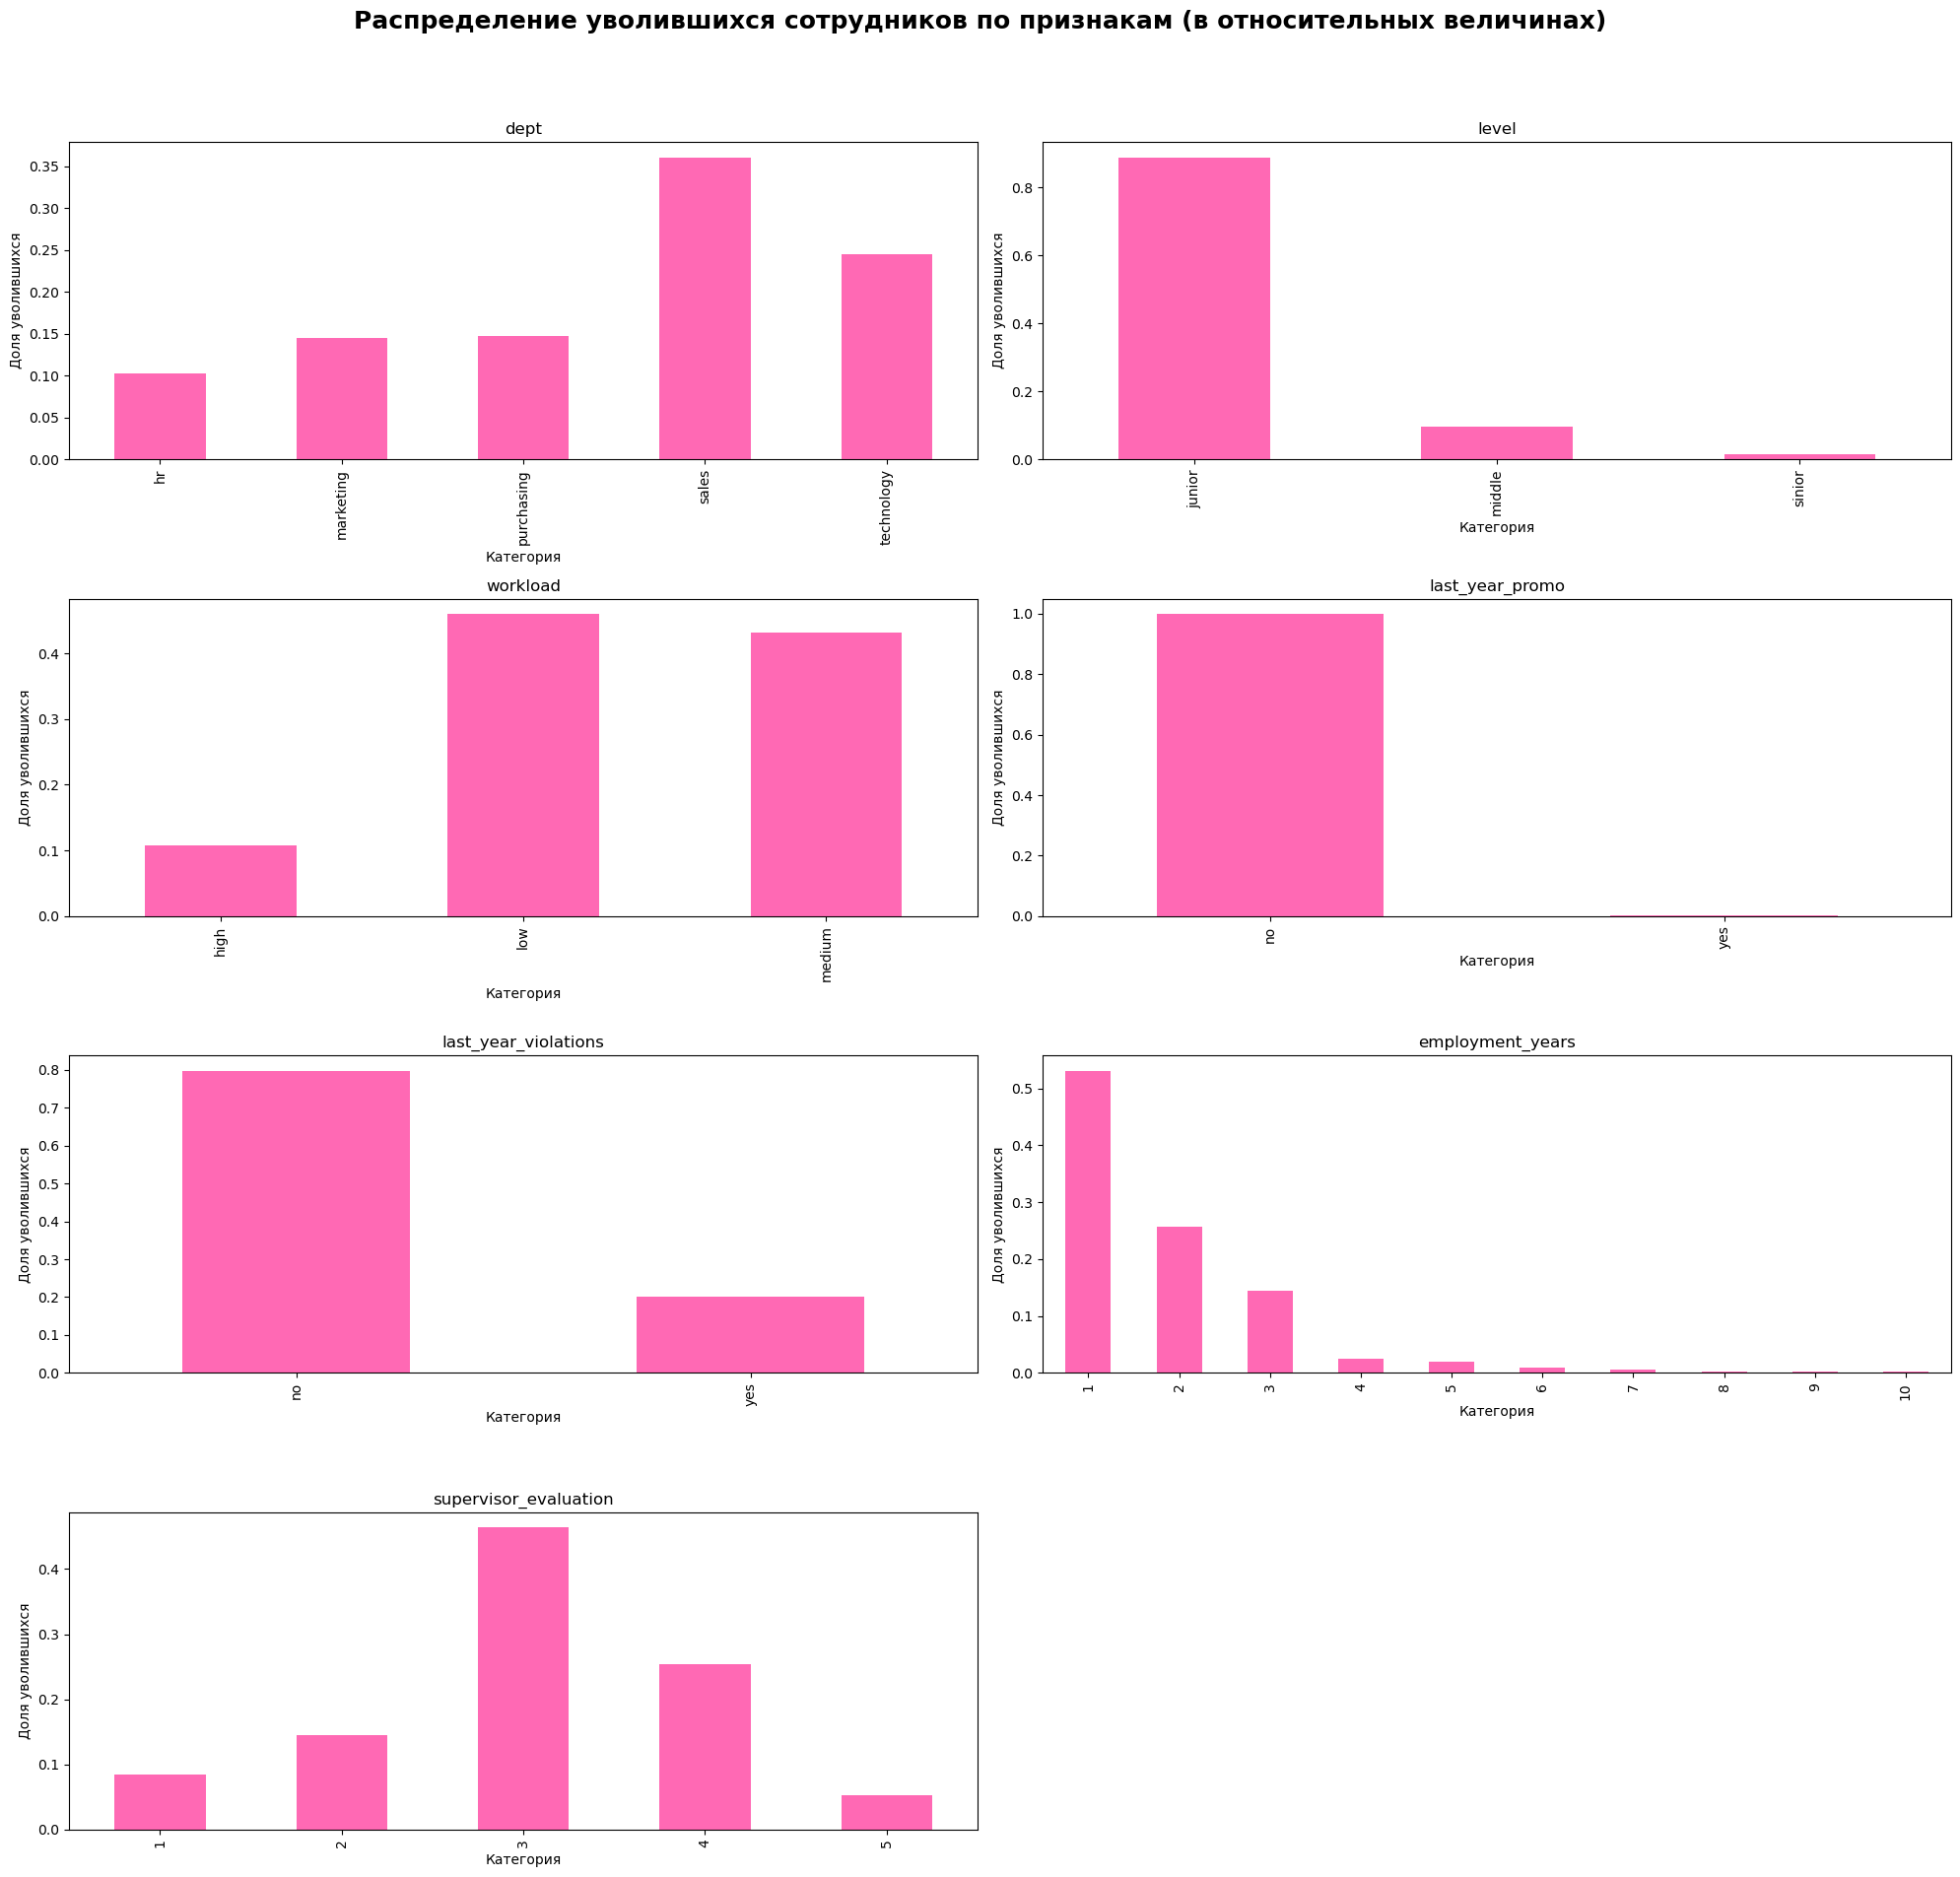

In [136]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
plt.suptitle("Распределение уволившихся сотрудников по признакам (в относительных величинах)", fontsize=18, fontweight='bold')

for i, feature in enumerate(categorical_features):
    ax = axes[i // 2, i % 2]
    quit_yes[feature].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax, color = 'hotpink')
    ax.set_title(f'{feature}')
    ax.set_ylabel('Доля уволившихся')
    ax.set_xlabel('Категория')
fig.delaxes(axes[3,1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [137]:
avg_salary_by_quit = train1.groupby('quit')['salary'].mean()
print("Средняя зарплата по признаку увольнения:")
print(avg_salary_by_quit)

Средняя зарплата по признаку увольнения:
quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


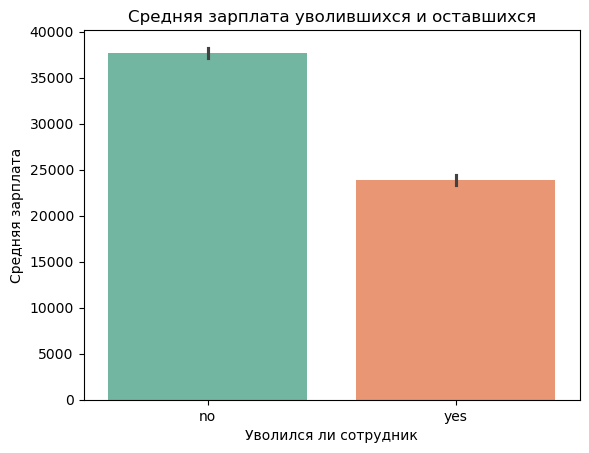

In [138]:
sns.barplot(x='quit', y='salary', data=train1, estimator='mean', palette='Set2')
plt.title('Средняя зарплата уволившихся и оставшихся')
plt.ylabel('Средняя зарплата')
plt.xlabel('Уволился ли сотрудник')
plt.show()

**Вывод:** 

* Больше всего увольняются сотрудники с уровнем должности junior, с уровнем загруженности работой low, имеющие низкие оценки руководителя (от 1 до 3) и недавно работающие в компании.
* Отдел, в котором работает сотрудник, на увольнение не влияет.
* Средние зарплаты уволившихся сотрудников в сравнении с продолжающими работать ниже, причем во всех категориях (во всех отделах, во всех уровнях загруженности, во всех уровнях должности, со всеми оценками работодателя).
* Если сотрудник был повышен в прошлом году, он не увольняется из компании.

**Типичный уволенный сотрудник - это недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой.**

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Нам нужно проверить, так ли это. Для этого добавим в тестовую выборку с целевым признаком `yвольнение` целевой признак из первой задачи `удовлетворенность работой)` и проведем корреляцию между ними.

In [145]:
data1=y_test.merge(y_test1, on='id')

In [146]:
data1=data1.set_index('id')

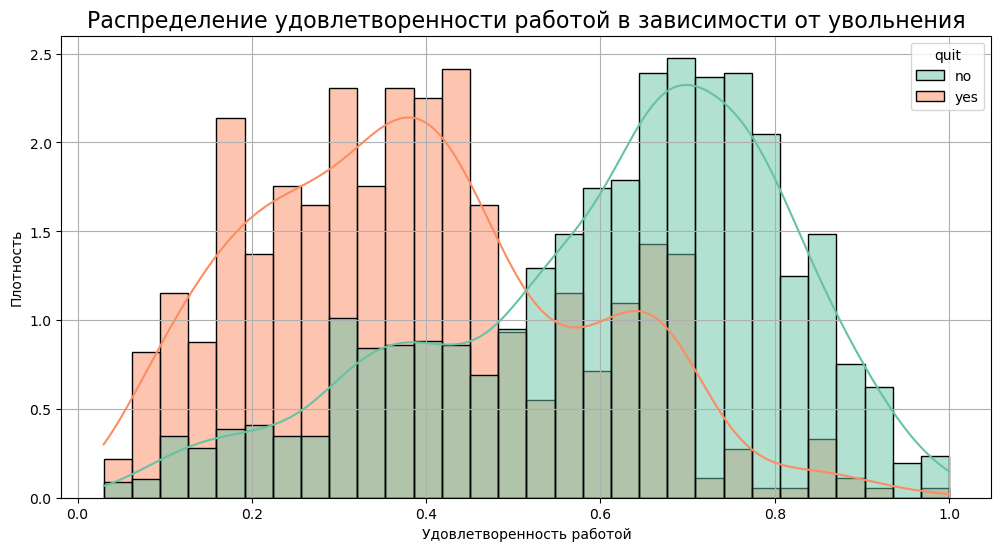

In [147]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data1, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False, bins=30, kde=True, palette='Set2')
plt.title('Распределение удовлетворенности работой в зависимости от увольнения', fontsize=16)
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

**Вывод:** 
* Работники с рейтингом удовлетворенности работой ниже 0.6 очень сильно преобладают в увольнении.
* Работники с рейтингом выше 0.6 не выбирают увольнение и прилично преобладают над уволившимися. 
* Удовлетворенность работой сильно влияет на целевой признак, а значит до обучения моделей нам нужно будет добавить этот признак в тренировочную и тестовую выборки.

### Добавление нового входного признака

In [154]:
X_test1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_test)
X_test1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.837297
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826
2,467458,sales,middle,low,5,no,no,4,19200,0.664000
3,418655,sales,middle,low,6,no,no,4,19200,0.664000
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978


In [155]:
train1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(train1.drop(['quit'], axis=1))
train1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.602105
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.837297
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.813636


***Вывод:*** Мы добавили новый входной признак в тестовую и тренировочную выборки и готовы к подготовке данных для обучения моделей.

### Подготовка данных

In [159]:
train_temp1 = train1.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp1.duplicated().sum())

Количество дубликатов: 1413


In [160]:
train_temp1 = train_temp1.drop_duplicates().reset_index(drop=True)

In [161]:
X_train1 = train_temp1.drop(['quit'], axis=1)
y_train1 = train_temp1['quit']

In [162]:
test1 = X_test1.merge(y_test1, on='id')

In [163]:
X_test1_ = test1.drop(['quit','id'], axis=1)
y_test1_ = test1['quit']

In [164]:
label_encoder = LabelEncoder()
y_train1 = label_encoder.fit_transform(y_train1)
y_test1_ = label_encoder.transform(y_test1_)

In [166]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [167]:
pipe(ohe_columns, ord_columns, num_columns)

***Вывод:*** На этом этапе мы провели подготовку данных (кодирование (в том числе целевого признака), масштабирование, обработка пропусков) с использованием пайплайна. И теперь мы готовы приступить к обучению моделей.

### 2.6 Обучение моделей

Целевой признак у нас один - `увольнение`. Вариантов у него всего 2 - да или нет. Перед нами стоит задача бинарной классификации. Для бинарной классификации нам подойдут модели логистической регрессии, метод опорных векторов, KNN и дерево решений.

In [171]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(6, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf',
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

In [249]:
random_search_full = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_full.fit(X_train1, y_train1)
auc_full = random_search_full.best_score_

In [251]:
print('Лучшая модель и её параметры:\n\n', random_search_full.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search_full.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

**Лучшей моделью оказалось дерево решений с максимальной глубиной 5 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 7.** 

Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику ROC_AUC.

In [256]:
y_test_proba = random_search_full.predict_proba(X_test1_)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.907661278373733


**Результат метрики получился 0.908, то есть практически такой же, как на тренировочной выборке. Значит наша модель справляется хорошо, но недостаточно.**

Проанализируем важность признаков для модели, чтобы понять, есть ли лишние признаки. Для этого воспользуемся модулем shap.

In [259]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train1)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test1_)

PermutationExplainer explainer: 2001it [00:25, 53.49it/s]                                                              


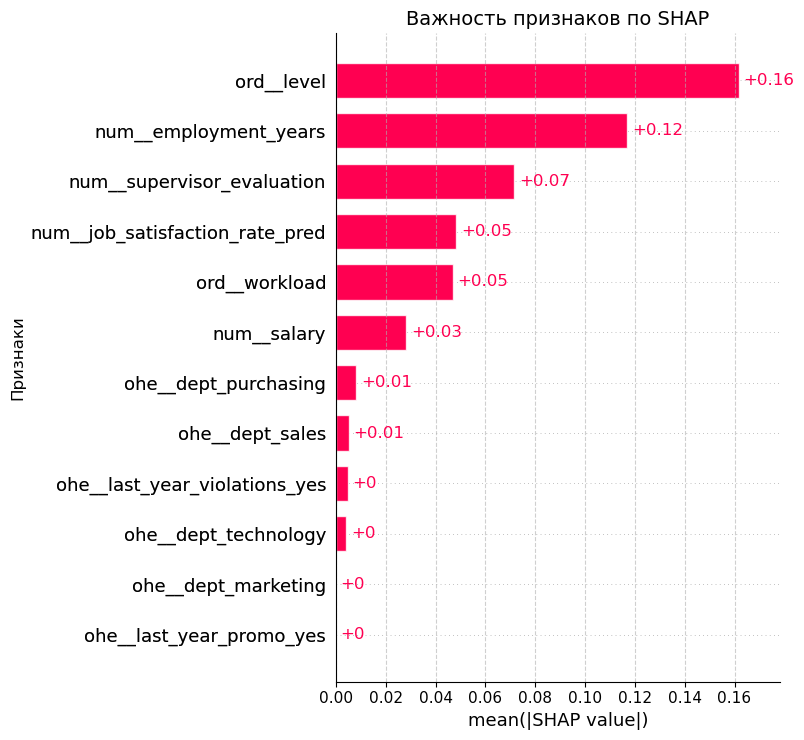

In [264]:
explainer = shap.PermutationExplainer(random_search_full.best_estimator_.named_steps['models'].predict_proba, X_test_transformed)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer.feature_names = feature_names
shap_values_ = explainer(X_test_transformed)

# Создаем пустую фигуру и ось заранее
fig, ax = plt.subplots(figsize=(8, 10))

shap.plots.bar(shap_values_[:, :, 1], max_display=16, show=False) 
plt.title('Важность признаков по SHAP', fontsize=14)
plt.ylabel('Признаки', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

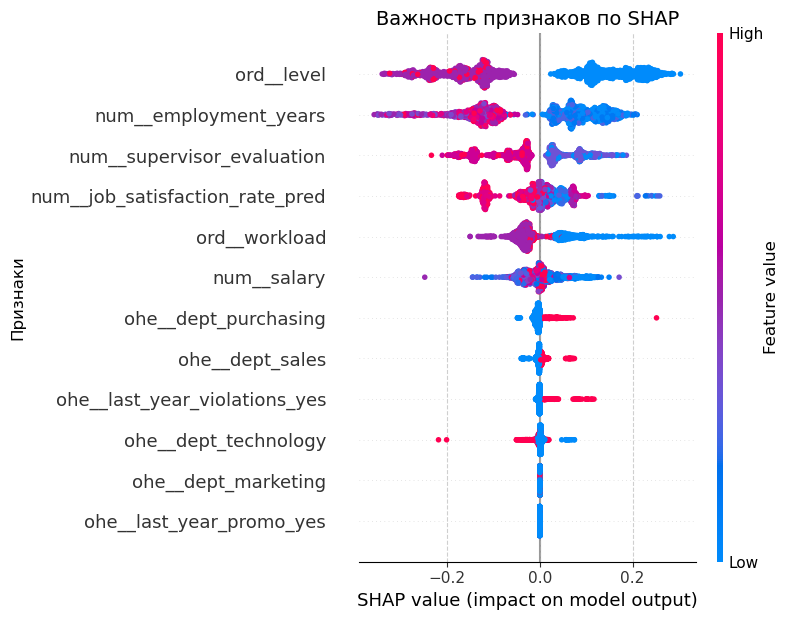

In [266]:
fig, ax = plt.subplots(figsize=(8, 10))
shap.plots.beeswarm(shap_values_[:,:,1], max_display=16, show=False) 
plt.title('Важность признаков по SHAP', fontsize=14)
plt.ylabel('Признаки', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

* Наиболее важным оказался признак level
* Признаки с повышением сотрудника, нарушением трудового договора и отделом похоже мало влияют на нашу модель.

**Попробуем убрать их и посмотрим, изменится ли результат метрики.**

In [273]:
X_train2 = X_train1.drop(['dept','last_year_promo','last_year_violations'], axis=1)
X_test2 = X_test1_.drop(['dept'], axis=1)
X_train2.shape, X_test2.shape

((2587, 6), (2000, 8))

In [275]:
ohe_columns = [ 
    
    
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [277]:
pipe(ohe_columns, ord_columns, num_columns)

In [279]:
random_search_reduced = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_reduced.fit(X_train2, y_train1)
auc_reduced = random_search_reduced.best_score_

In [281]:
# Сравнение
if auc_reduced > auc_full:
    best_model = random_search_reduced.best_estimator_
    X_test_final = X_test2
else:
    best_model = random_search_full.best_estimator_
    X_test_final = X_test1_

In [283]:
print('Лучшая модель и её параметры:\n\n', random_search_reduced.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search_reduced.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                          

In [287]:
y_test_proba = random_search_reduced.predict_proba(X_test_final)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9177093828404352


* Результат улучшился и теперь метрика составляет почти 0.92.
* Удаление ненужных признаков не только увеличивают метрику качества, но и уменьшают время на работу алгоритма по поиску параметров. 

**Вывод:** 

Мы завершили работу над второй задачей и обучили модель предсказывать, уволится сотрудник из компании или нет. Лучшей моделью для этой задачи оказалось дерево решений (точность предсказаний около 91%).
Вероятно дерево решений справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров.

## Общие выводы

В рамках исследования были проделаны следующие шаги:
1. Загрузка данных
Исходными данными для исследования были три отдельных csv файла:

* с тренировочными данными о работниках компании.
* с тестовыми данными о работниках компании.
* с тестовым целевым признаком
* дополнительный датасет был загружен для создания второй модели

2. Предобработка данных
Исходные данные оказались хорошего качества, но тем не менее они требовали проведения некоторых работ перед началом анализа. 
* Избавление от пропусков.
* Проверка неявных дубликатов.

3. Исследовательский анализ данных
На этом этапе были построены диаграммы распределения всех признаков. С помощью графиков были рассмотрены распределения признаков и получены следующие выводы:
* `salary` распределен не совсем нормально, имеется сдвиг влево. На диаграмме мы видим выбросы, но так как они достигают 100 000, что является абсолютно реальным зарплатным решением, удалять их не стоит. Вполне логично, что людей с высокой зарплатой меньше, поэтому такие значения определяются как выбросы.
* `job_satisfaction_rate` тоже имеет не совсем нормальное распределение, сдвиг идет вправо. Выбросов не наблюдается
* `employment_years` преобладают сотрудники, которые работают в компании один год, видно, что чем больше лет в компании, тем меньше сотрудников.
* `supervisor_evaluation` в оценках сотрудников преобладают оценки 3 и 4. 
* `dept` преобладают сотрудники, которые работают в отделе продаж, на втором место технический, остальные распределены примерно одинаково.
* `level` по уровню занимаемой должности равномерно преобладаются junior и middle сотрудники, senior меньше, что логично, сотрудников с таким опытом всегда мало.
* `workload` по уровню загруженности самый большой сегмент отвечает за среднюю, на втором месте низкий, высокий уровень загруженности - самый не многочисленный.
* `last_year_promo` повышение за прошлый год было только у 3% сотрудников.
* `last_year_violations` нарушение договора за прошлый год выявлено у 14% сотрудников.
4. Так как целевой признак у нас непрерывный количественный, то для для обучения мы взяли две модели регрессии: модель линейной регрессии и дерево решений (для дерева решений использовали перебор разных гиперпараметров). 
* Провели обучение моделей, выбрали лучшую на основе метрики SMAPE.
* Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10.
* После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.
* Вероятно дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров.

Для второй задачи:
1. Провели загрузку новых данных. В новых датасетах пропусков и дублей нет. В тренировочной выборке всё так же 4000 строк, в тестовой 2000.
2. Провели предобработку данных. В новых колонках quit в тренировочной и тестовой выборках ошибок не обнаружено. Данные распределены так же, как в первой задаче.
3. Провели исследовательский анализ данных, посмотрели распределение нового признака Увольнение, составили портрет "типичного" увольняющегося сотрудника:
* Больше всего увольняются сотрудники с уровнем должности junior, с уровнем загруженности работой low, имеющие низкие оценки руководителя (от 1 до 3) и недавно работающие в компании.
* Отдел, в котором работает сотрудник, на увольнение не влияет.
* Средние зарплаты уволившихся сотрудников в сравнении с продолжающими работать ниже, причем во всех категориях (во всех отделах, во всех уровнях загруженности, во всех уровнях должности, со всеми оценками работодателя).

**Типичный уволенный сотрудник - это недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой.**
4. Добавили новый входной признак (удовлетворенность работой) в тестовую и тренировочную выборки.
5. Провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна.
6. Целевой признак у нас один - Увольнение. Вариантов у него всего 2 - да или нет. А значит это задача бинарной классификации. Для бинарной классификации мы использовали модели логистической регрессии, метод опорных векторов, KNN и дерево решений (для всех использовали перебор разных гиперпараметров). Провели обучение моделей, выбрали лучшую на основе метрики ROC_AUC. Лучшей моделью для этой задачи оказалось дерево решений с максимальной глубиной 5 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 7 (точность предсказаний около 91%). После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.
Затем мы проанализировали важность признаков для модели. Убрали неважные признаки (повышение сотрудников, отдел, нарушение трудового договора). Результат метрики улучшился и составил почти 0.92. Удалив ненужные признаки, мы не только увеличили метрику, но и уменьшили время на работу алгоритма по поиску параметров. Это бывает очень важно, когда требуется, чтобы модель часто пересчитывала коэффициенты при поступлении новых данных в реальном времени.

**Среди пожеланий заказчику можно отметить, что для того, чтобы сотрудники меньше увольнялись, нужно следить за их удовлетворенностью работой, быстрее переводить из разряда junior в разряд medium, больше загружать работой (соответственно будет выше зарплата).**